# Set Up
Set up the Google Colab environment and import dependent libraries.

In [1]:
#Loading data from Google drive
import os

try:
  from google.colab import drive
  drive.mount('/content/drive')
  os.chdir("/content/drive/My Drive/PAN14_Code")
  RUNNING_COLAB = True
except ImportError:
  print("I have a sneaking suspicion that I'm not running on Google Colab")
  RUNNING_COLAB = False


I have a sneaking suspicion that I'm not running on Google Colab


In [2]:
# Lambda to print module versions
ver = lambda module : print(f"{module.__name__}=={module.__version__}")

In [3]:
import sys
import json
import math
import csv
import numpy as np
import glob
import pickle
import itertools
from collections import Counter
ver(np)

#pip install nltk
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#nltk.download(["punkt", "stopwords","wordnet"])
ver(nltk)

# Uncomment to suppress tensorflow output, if need
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.callbacks import EarlyStopping
ver(tf)

#pip install gensim
import gensim
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import common_texts
ver(gensim)

#pip install scikit-learn
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from scipy.spatial.distance import cosine
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from collections import defaultdict

#pip install networkx
import networkx as nx
import random
from tqdm import tqdm
from urllib.request import urlretrieve
ver(nx)

#pip install matplotlib
import matplotlib.pyplot as plt
import string

numpy==1.24.3
nltk==3.8.1


2023-10-25 04:21:47.234890: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-25 04:21:47.236416: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-25 04:21:47.267089: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-25 04:21:47.268035: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-25 04:21:47.902458: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

tensorflow==2.13.0
gensim==4.3.2
networkx==3.1


In [4]:
def nltk_setup(path = None):
  """Initialize and download the right modules"""
  if type(path) is None:
    # No change to default path (defaults to user home directory)
    nltk.download(["punkt", "stopwords","wordnet"])
  else:
    # Change default path
    nltk.data.path = [ path ]
    nltk.download(["punkt", "stopwords","wordnet"], download_dir=nltk.data.path[0])

nltk_setup(f"{os.path.curdir}/nltk_data")

[nltk_data] Downloading package punkt to ./nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to ./nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to ./nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
def print_colab_stats():
  # GPU info
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
  else:
    print(gpu_info)

  # Memory Info
  from psutil import virtual_memory
  ram_gb = virtual_memory().total / 1e9
  print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

  if ram_gb < 20:
    print('Not using a high-RAM runtime')
  else:
    print('You are using a high-RAM runtime!')

if RUNNING_COLAB: print_colab_stats()

# Data Process
Read the data in and save it in the dict.

In [6]:
def get_data_directory_path(subdirectory):
    return os.path.join('data', subdirectory)


def get_json_file_path(data_directory, file_name):
    return os.path.join(data_directory, file_name)


def read_json_file(file_path):
    with open(file_path) as file:
        data = json.load(file)
    return data


def extract_text_from_files(file_paths):
    known_text, unknown_text = [], []

    for file_path in file_paths:
        text_lines = []
        with open(file_path, 'r') as file:
            for line in file:
                cleaned_line = line.strip().lstrip("\ufeff")
                text_lines.append(cleaned_line)
        if 'unknown' in file_path:
            unknown_text.append(text_lines)
        else:
            known_text.append(text_lines)

    return known_text, unknown_text


def build_corpus(data_directory, content_data, label_data):
    corpus = {}

    for index in tqdm(range(len(content_data['problems']))):
        problem_file_paths = glob.glob(os.path.join(data_directory, content_data['problems'][index], '*'))

        if not problem_file_paths:
            continue

        known_text, unknown_text = extract_text_from_files(problem_file_paths)
        label = 1 if label_data['problems'][index]['answer'] == 'Y' else 0

        corpus[index] = {
            'known': known_text,
            'unknown': unknown_text,
            'label': label
        }

    return corpus

In [7]:
# Get data path
train_data_directory = get_data_directory_path('train_data')
validation_data_directory = get_data_directory_path('val_data')
test_data_directory = get_data_directory_path('test_data')

In [8]:
# Train
train_content = read_json_file(get_json_file_path(train_data_directory, 'contents.json'))
train_labels = read_json_file(get_json_file_path(train_data_directory, 'truth.json'))
# # Val
#validation_content = read_json_file(get_json_file_path(validation_data_directory, 'contents.json'))
#validation_labels = read_json_file(get_json_file_path(validation_data_directory, 'truth.json'))
# Test
test_content = read_json_file(get_json_file_path(test_data_directory, 'contents.json'))
test_labels = read_json_file(get_json_file_path(test_data_directory, 'truth.json'))

In [9]:
# Get train corpus
train_corpus = build_corpus(train_data_directory, train_content, train_labels)
# # Get val corpus
#val_corpus = build_corpus(validation_data_directory, validation_content, validation_labels)
# Get test corpus
test_corpus = build_corpus(test_data_directory, test_content, test_labels)

100%|██████████| 200/200 [00:00<00:00, 6146.54it/s]


In [10]:
# Split the training data into training and validation
def split_data_into_train_and_val(data_dict, test_size=0.2, random_state=42):
    document_ids, labels = zip(*[(doc_id, data['label']) for doc_id, data in data_dict.items()])

    train_ids, val_ids, train_labels, val_labels = train_test_split(document_ids, labels, test_size=test_size, random_state=random_state)

    train_data = {doc_id: data_dict[doc_id] for doc_id in train_ids}
    validation_data = {doc_id: data_dict[doc_id] for doc_id in val_ids}

    return train_data, validation_data

train_corpus, val_corpus = split_data_into_train_and_val(data_dict=train_corpus)

# Train Word2Vec Model

In [11]:
def preprocess_text(text):
    """
    Preprocess a given text by tokenizing, removing punctuation and numbers,
    removing stop words, and lemmatizing.

    Args:
        text (str): The text to preprocess.

    Returns:
        list: The preprocessed text as a list of tokens.
    """
    if not isinstance(text, str):
        text = str(text)

    # Tokenize the text into words
    tokens = word_tokenize(text.lower())

    # Remove punctuation and numbers
    table = str.maketrans('', '', string.punctuation + string.digits)
    tokens = [word.translate(table) for word in tokens]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if (not word in stop_words) and (word != '')]

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

def train_word2vec_model(data, vector_size):
    """
    Train a word2vec model using the given data.

    Args:
        data (dict): The data to use for training the model.
        vector_size (int): The size of the word vectors in the model.

    Returns:
        gensim.models.Word2Vec: The trained word2vec model.
    """
    corpus = []

    # Process all articles in the data
    for articles in tqdm(data.values(), total=len(data)):
        all_articles = []
        all_articles.extend(articles['known'])
        all_articles.extend(articles['unknown'])

        for article in all_articles:
            for line in article:
                text = line.strip()
                tokens = preprocess_text(text)
                corpus.append(tokens)

    # Train the word2vec model
    word2vec_model = gensim.models.Word2Vec(vector_size=vector_size, window=5, min_count=1, workers=4)
    word2vec_model.build_vocab(corpus)
    word2vec_model.train(corpus, total_examples=word2vec_model.corpus_count, epochs=word2vec_model.epochs)

    return word2vec_model

In [12]:
# Size of word vectors in the word2vec model
w2v_vector_size = 300

In [13]:
# Train a word2vec model using the training corpus
word2vec_model = train_word2vec_model(train_corpus, w2v_vector_size)

100%|██████████| 154/154 [00:05<00:00, 28.50it/s]


# Vectorize Text Data

In [14]:
def convert_text_to_vector(texts, model, vector_size):
    """
    Convert a list of texts into their corresponding word2vec vectors
    """
    vectors = []
    for text in texts:
        words = preprocess_text(text)
        vector = np.sum([model.wv[word] for word in words if word in model.wv], axis=0)
        word_count = np.sum([word in model.wv for word in words])
        if word_count != 0:
            vector /= word_count
        else:
          vector = np.zeros(vector_size)
        vectors.append(vector)
    return vectors

In [15]:
def count_punctuations(texts):
  """
  Count the frequency of different punctuations in the texts
  """
  # Define punctuations to count
  punctuations = set(['.', ',', ';', ':', '!', '?', '-', '(', ')', '\"', '\'', '`', '/'])

  # Initialize dictionary to count punctuations
  punctuations_count = {p: 0 for p in punctuations}

  # Count punctuations in text_list
  for text in texts:
      for char in text:
          if char in punctuations:
              punctuations_count[char] += 1

  # Return list of punctuation counts
  return list(punctuations_count.values())

In [16]:
def analyze_sentence_lengths(text):
  """
  Analyze the lengths of sentences
  (Modified to operate on a single text)
  """  
  sentences = sent_tokenize(text)

  sentence_lengths = [len(sentence.split()) for sentence in sentences]
  average_length = np.mean(sentence_lengths)
  count_over_avg = np.sum([length > average_length for length in sentence_lengths])
  count_under_avg = np.sum([length < average_length for length in sentence_lengths])
  count_avg = len(sentence_lengths) - count_over_avg - count_under_avg

  return [count_over_avg, count_under_avg, count_avg, average_length]

In [17]:
def analyze_words(text):
    """
    Analyze the words used in the texts
    (modified to operate on a single text, as that's how it's used)
    """
    #words = []
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    # Previously a for loop to iterate over all texts.
    # However function is only actually called on a single text
    tokenized = word_tokenize(text.lower())
    processed = [lemmatizer.lemmatize(word) for word in tokenized if word not in stop_words]
    words = processed
    
    word_freq = nltk.FreqDist(words)
    rare_count = np.sum([freq <= 2 for word, freq in word_freq.items()])
    long_count = np.sum([len(word) > 6 for word in words])
    word_lengths = [len(word) for word in words]
    average_length = np.mean(word_lengths)
    count_over_avg = np.sum([length > average_length for length in word_lengths])
    count_under_avg = np.sum([length < average_length for length in word_lengths])
    count_avg = len(word_lengths) - count_over_avg - count_under_avg
    ttr = len(set(words)) / len(words) if words else 0

    return [rare_count, long_count, count_over_avg, count_under_avg, count_avg, ttr]

In [18]:
def calculate_style_vector(text):
  """
  Calculate the style vector of the texts
  (Modified to operate on a single text at a time,
  as get_vector only passes one at a time)
  """
  if type(text) is list:
    # Merge split lines back into a single string
    text = '\n'.join(text)

  punctuation_vec = count_punctuations(text)     # Punctuations stylistic features
  sentence_vec = analyze_sentence_lengths(text)  # Sentences stylistic features
  word_vec = analyze_words(text)                 # Words stylistic features
  word_count = len(word_tokenize(text))

  vector = np.concatenate((punctuation_vec, sentence_vec, word_vec))

  return vector / word_count if word_count else vector

In [19]:
def get_vectors(texts, w2v_model):
  res = []
  for text in texts:
    w2v_vec = np.mean(convert_text_to_vector(text, w2v_model, w2v_vector_size), axis=0)
    style_vec = calculate_style_vector(text)
    res.append(np.concatenate((w2v_vec, style_vec), axis=None))
    # res.append(w2v_vec)

  return res

In [20]:
def vectorize_text_data(data, w2v_model):
  """
  Build author data from the corpus
  """
  res = {}
  for key,val in tqdm(data.items(), total=len(data)):
    if len(val['unknown']) == 0:
      continue
    res[key] = {
        'known': get_vectors(val['known'], w2v_model),
        'unknown': get_vectors(val['unknown'], w2v_model),
        'label': val['label']
    }

  return res

In [21]:
train_data = vectorize_text_data(train_corpus, word2vec_model)
val_data = vectorize_text_data(val_corpus, word2vec_model)
test_data = vectorize_text_data(test_corpus, word2vec_model)

100%|██████████| 200/200 [00:14<00:00, 14.26it/s]


# Build Triplet Samples

In [22]:
# Random triplet mining
def build_random_triplet_sample(data):
  """
  This function creates random triplet samples from the input data
  """

  keys_list = list(data.keys())
  triplet_samples = {}

  # Initialize the lists for storing the anchor, positive, and negative samples
  anchors, positives, negatives = [], [], []

  for key,val in tqdm(data.items(), total=len(data)):
    n = len(val['known'])
    for i in range(n):
      for j in range(i+1, n):
        anchors.append(val['known'][i])
        positives.append(val['known'][j])
        # Get negative sample
        while True:
          random_key = random.choices(keys_list, k=1)
          if random_key != key:
            break
        random_neg_sample = random.choices(data[random_key[0]]['known'], k=1)
        negatives.append(random_neg_sample[0])


  # Build triplet sample
  for i in range(len(anchors)):
    triplet_samples[i] = {
        'anchor': anchors[i],
        'positive': positives[i],
        'negative': negatives[i]
    }

  return triplet_samples

In [23]:
random_triplet_samples = build_random_triplet_sample(train_data)

100%|██████████| 152/152 [00:00<00:00, 88448.14it/s]


In [24]:
anchor_data = np.array([data['anchor'] for data in random_triplet_samples.values()])
positive_data = np.array([data['positive'] for data in random_triplet_samples.values()])
negative_data = np.array([data['negative'] for data in random_triplet_samples.values()])
labels_data = np.array([0 for _ in random_triplet_samples.values()])

In [25]:
val_random_triplet_samples = build_random_triplet_sample(val_data)

100%|██████████| 39/39 [00:00<00:00, 48858.38it/s]


In [26]:
val_anchor_data = np.array([data['anchor'] for data in val_random_triplet_samples.values()])
val_positive_data = np.array([data['positive'] for data in val_random_triplet_samples.values()])
val_negative_data = np.array([data['negative'] for data in val_random_triplet_samples.values()])
val_labels_data = np.array([0 for _ in val_random_triplet_samples.values()])

# Build SiameseNet Model

## Model Frame

In [27]:
class SiameseNet(tf.keras.Model):
    def __init__(self, base_network, clf_network):
        super().__init__()
        self.base = base_network
        self.clf = clf_network

    def call(self, inputs):
        anchor = inputs[0]
        positive = inputs[1]
        negative = inputs[2]

        output_anchor = self.base(anchor)
        output_positive = self.base(positive)
        output_negative = self.base(negative)

        # Anchor - Positive
        x1 = tf.concat([output_anchor, output_positive], axis=-1)
        x1_out = self.clf(x1)

        # Anchor - Negative
        x2 = tf.concat([output_anchor, output_negative], axis=-1)
        x2_out = self.clf(x2)

        return (x1_out, x2_out)

In [28]:
def create_dense_block(x, units, dropout_rate, l1_reg, l2_reg):
    x = tf.keras.layers.Dense(units, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return tf.keras.layers.Dropout(dropout_rate)(x)

In [29]:
# Define the base network
def create_base_network(embedding_dim, dropout_rate=0.4, l1_reg=0.001, l2_reg=0.001):
    input = tf.keras.layers.Input(shape=embedding_dim)
    x = tf.keras.layers.BatchNormalization()(input)

    x = create_dense_block(x, 256, dropout_rate, l1_reg, l2_reg)
    x = create_dense_block(x, 128, dropout_rate, l1_reg, l2_reg)
    x = create_dense_block(x, 64, dropout_rate, l1_reg, l2_reg)

    x = tf.keras.layers.Dense(64, activation='linear')(x)

    return tf.keras.Model(inputs=input, outputs=x)

In [30]:
def create_clf_network(input_shape, dropout_rate=0.5, l1_reg=0.003, l2_reg=0.003):
    input = tf.keras.layers.Input(shape=(input_shape,))
    x = tf.keras.layers.BatchNormalization()(input)

    x = create_dense_block(x, 128, dropout_rate, l1_reg, l2_reg)
    x = create_dense_block(x, 64, dropout_rate, l1_reg, l2_reg)
    x = create_dense_block(x, 32, dropout_rate, l1_reg, l2_reg)

    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model(inputs=input, outputs=x)


In [31]:
def customer_loss(y_true, y_pred):
    AP = y_pred[0]
    AN = y_pred[1]

    loss = 1.0 - AP + AN

    return loss

## Construct the Model

In [32]:
# Define the embedding dimension
embedding_dim = anchor_data[0].shape

# Create base network
base_network = create_base_network(embedding_dim)
clf_network = create_clf_network(base_network.output_shape[1]*2)

siamese_model = SiameseNet(base_network, clf_network)

In [33]:
input_anchor = tf.keras.layers.Input(shape=embedding_dim)
input_positive = tf.keras.layers.Input(shape=embedding_dim)
input_negative = tf.keras.layers.Input(shape=embedding_dim)

In [34]:
# Assemble siameseNet model
siamese_model.compile(optimizer='adam',
                      loss=customer_loss)

In [35]:
checkpoint_path = "model_weights/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_save = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                             save_weights_only=True,
                                             verbose=1)

## Load SiameseNet Model Weights

In [36]:
#latest = tf.train.latest_checkpoint(checkpoint_dir)
#siamese_model.load_weights(latest)
# Disabled for now since model loading is implemented under 'Production Use' at the end

## Train SiameseNet Model

### Train on Random Triplet Samples

In [37]:
# Train siameseNet model
early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1)
siamese_history = siamese_model.fit([anchor_data, positive_data, negative_data], labels_data,
                  epochs=1000,
                  validation_data=([val_anchor_data, val_positive_data, val_negative_data], val_labels_data),
                  callbacks=[early_stopping, cp_save])

Epoch 1/1000
11/15 [=====================>........] - ETA: 0s - loss: 16.9810 - output_1_loss: 1.0279 - output_2_loss: 1.0629 
Epoch 1: saving model to model_weights/cp.ckpt
15/15 [==============================] - 5s 43ms/step - loss: 17.0069 - output_1_loss: 1.0154 - output_2_loss: 1.1213 - val_loss: 16.7790 - val_output_1_loss: 1.0016 - val_output_2_loss: 1.0006
Epoch 2/1000
12/15 [=======================>......] - ETA: 0s - loss: 16.7251 - output_1_loss: 1.0200 - output_2_loss: 0.9923
Epoch 2: saving model to model_weights/cp.ckpt
15/15 [==============================] - 0s 9ms/step - loss: 16.7086 - output_1_loss: 1.0107 - output_2_loss: 0.9996 - val_loss: 16.6156 - val_output_1_loss: 1.0066 - val_output_2_loss: 1.0056
Epoch 3/1000
12/15 [=======================>......] - ETA: 0s - loss: 16.4609 - output_1_loss: 0.9021 - output_2_loss: 1.0174
Epoch 3: saving model to model_weights/cp.ckpt
15/15 [==============================] - 0s 10ms/step - loss: 16.4704 - output_1_loss: 0.9358

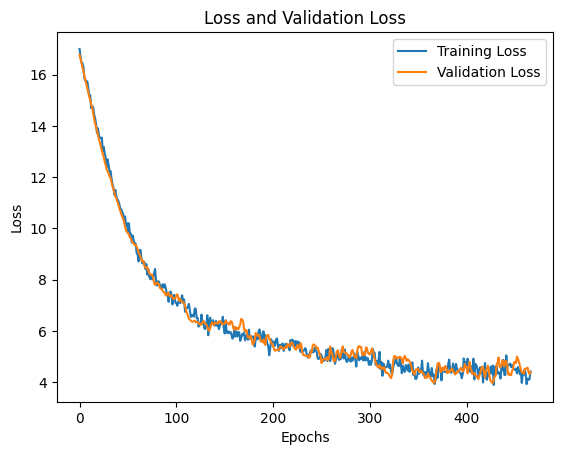

In [38]:
loss = siamese_history.history['loss']
val_loss = siamese_history.history['val_loss']

# Draw
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Train on Semi-Hard Triplet Samples

#### Semi-Hard Samples Construct

In [39]:
# Build semi-hard triplet sample candidates
def build_triplet_sample_candidates(data):
  res = {}

  keys = []
  anchors = []
  positives = []

  for key,val in tqdm(data.items(), total=len(data)):
    n = len(val['known'])
    for i in range(n-1):
      keys.append(key)
      anchors.append(val['known'][i])
      positives.append(val['known'][i+1:])

  for i in range(len(keys)):
    res[i] = {
        'key': keys[i],
        'anchor': anchors[i],
        'positives': positives[i]
    }

  return res

In [40]:
triplet_sample_candidates = build_triplet_sample_candidates(train_data)

100%|██████████| 152/152 [00:00<00:00, 512075.67it/s]


In [41]:
def create_negative_vectors_dict(data):
    negative_vectors_dict = {}
    key_list = list(data.keys())

    for key in tqdm(key_list, total=len(key_list)):
        negative_vectors_dict[key] = []
        for k,v in data.items():
            if k != key:
                for vec in v['known']:
                    negative_vectors_dict[key].append(vec)
    return negative_vectors_dict

In [42]:
negative_vectors_dict = create_negative_vectors_dict(train_data)

100%|██████████| 152/152 [00:00<00:00, 28164.61it/s]


In [43]:
def select_random_from_list(input_list):
    """
    Selects a random item from a list.
    """
    return input_list[np.random.randint(0, len(input_list))]

# def select_negative_vectors(negatives, key):
#     """
#     Collects all negative vectors except for the one corresponding to the key.
#     """
#     return [vec for k,v in negatives.items() if k != key for vec in v['known']]

def get_random_triplet(sample, negatives):
    """
    This function takes a sample and negatives, and returns a random triplet of anchor, positive, and negative.
    """
    # Select the positive vector
    positive = select_random_from_list(sample['positives'])

    # Select the negative vector
    negative = select_random_from_list(negatives[sample['key']])

    return sample['anchor'], positive, negative

def get_hard_triplet(sample, negatives, base_model, clf_model,):
    """
    This function takes a sample, negatives, and a model, and returns a hard triplet of anchor, positive, and negative.
    The sample with the lowest probability is the hardest positive sample,
    while a high probability indicates that the model is confident in classifying it as positive.
    Therefore, the lowest probability implies that the model has incorrectly classified it.
    """
    anchor_rep = base_model.predict(np.array([sample['anchor']]), verbose=0)

    ### ------ Positive ------ ###
    # Compute distances between anchor and all positive vectors
    positive_reps = base_model.predict(np.array(sample['positives']), verbose=0)
    AP_reps = []
    for rep in positive_reps:
        comb = np.concatenate((anchor_rep[0], rep), axis=None)
        AP_reps.append(comb)

    # Select the hardest positive (the one with the lowest probability)
    positive_distances = clf_model.predict(np.array(AP_reps), verbose=0)
    hardest_positive = sample['positives'][np.argmin(positive_distances)]


    ### ------ Negative ------ ###
    # Collect all negative vectors and compute distances to anchor
    negative_vectors = negatives[sample['key']]
    negative_reps = base_model.predict(np.array(negative_vectors), verbose=0)
    AN_reps = []
    for rep in negative_reps:
        comb = np.concatenate((anchor_rep[0], rep), axis=None)
        AN_reps.append(comb)

    # Select the hardest negative (the one with the highest probability)
    negative_distances = clf_model.predict(np.array(AN_reps), verbose=0)
    hardest_negative = negative_vectors[np.argmax(negative_distances)]

    # # positive_distances = [compute_cosine_distance(pos_rep, anchor_rep[0]) for pos_rep in positive_reps]
    # positive_distances = [np.sum(np.square(pos_rep - anchor_rep[0])) for pos_rep in positive_reps]

    # # Select the hardest positive (the one with the largest distance)
    # hardest_positive = sample['positives'][np.argmax(positive_distances)]

    # # Collect all negative vectors and compute distances to anchor
    # negative_vectors = select_negative_vectors(negatives, sample['key'])
    # negative_reps = model.predict(np.array(negative_vectors), verbose=0)
    # negative_distances = [np.sum(np.square(neg_rep - anchor_rep[0])) for neg_rep in negative_reps]

    # # Select the hardest negative (the one with the smallest distance)
    # hardest_negative = negative_vectors[np.argmin(negative_distances)]

    return sample['anchor'], hardest_positive, hardest_negative

def get_triplet(sample, negatives, base_model, clf_model, hard_triplet_probability):
    """
    This function decides between selecting a hard triplet or a random triplet based on the hard_triplet_probability.
    """
    if np.random.rand() < hard_triplet_probability:
        # With a certain probability, choose the hardest triplet
        return get_hard_triplet(sample, negatives, base_model, clf_model)
    else:
        # Otherwise, choose a random triplet
        return get_random_triplet(sample, negatives)


#### Training on Semi-Hard Samples

In [44]:
num_epochs = 100
patience = 10
previous_loss = float('inf')

hard_triplet_probability_start=0.5
hard_triplet_probability_end=0.8

early_stopping_2 = EarlyStopping(monitor='loss', patience=patience, verbose=0)

In [45]:
# Initial probability of selecting a hard triplet
triplet_select_probability = hard_triplet_probability_start

# Iterate over each epoch
for epoch in tqdm(range(num_epochs)):
  # Initialize empty lists for anchor, positive, negative samples and labels
  anchor_samples = []
  positive_samples = []
  negative_samples = []
  labels = []

  # Iterate over triplet samples
  for _, sample in triplet_sample_candidates.items():
    # Get the anchor, positive, negative samples
    anchor, positive, negative = get_triplet(sample, negative_vectors_dict, base_network, clf_network, triplet_select_probability)
    # Add samples to their respective lists
    anchor_samples.append(anchor)
    positive_samples.append(positive)
    negative_samples.append(negative)
    labels.append(0)

  # Convert lists to numpy arrays
  anchor_samples = np.array(anchor_samples)
  positive_samples = np.array(positive_samples)
  negative_samples = np.array(negative_samples)
  labels = np.array(labels)

  # Train the model on current epoch's data
  siamese_model.fit([anchor_samples, positive_samples, negative_samples], labels,
                    epochs=50,
                    verbose=1,
                    callbacks=[early_stopping_2, cp_save])

  # Gradually increase the probability of choosing a hard triplet
  triplet_select_probability += (hard_triplet_probability_end - hard_triplet_probability_start) / num_epochs

  # Uncomment the following section for Early Stopping
  # Check if current epoch is a 'patience' epoch
  if epoch % patience == 0 and epoch != 0:
    current_loss = siamese_model.history.history['loss'][-1]
    # Check if loss is increasing or constant, if yes, then stop training
    if current_loss >= previous_loss:
      print("Early stopping triggered. Stopping training.")
      break
    else:
      # Update previous loss with current loss
      previous_loss = current_loss

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/50
1/8 [==>...........................] - ETA: 0s - loss: 4.6117 - output_1_loss: 1.3250 - output_2_loss: 1.0902
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 11ms/step - loss: 4.4045 - output_1_loss: 1.1201 - output_2_loss: 1.0857
Epoch 2/50
1/8 [==>...........................] - ETA: 0s - loss: 3.3293 - output_1_loss: 0.6592 - output_2_loss: 0.4690
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 10ms/step - loss: 4.1108 - output_1_loss: 1.0468 - output_2_loss: 0.8614
Epoch 3/50
1/8 [==>...........................] - ETA: 0s - loss: 5.6992 - output_1_loss: 1.9674 - output_2_loss: 1.5308
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 11ms/step - loss: 4.4378 - output_1_loss: 1.1375 - output_2_loss: 1.1000
Epoch 4/50
1/8 [==>...........................] - ETA: 0s - loss: 4.0949 - output_1_loss: 0.4232 - output_2_loss: 1.4723
Epoch 4: saving model to model

  1%|          | 1/100 [00:27<44:52, 27.20s/it]

Epoch 1/50
1/8 [==>...........................] - ETA: 0s - loss: 4.9345 - output_1_loss: 1.4112 - output_2_loss: 1.4549
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 12ms/step - loss: 4.1991 - output_1_loss: 1.2405 - output_2_loss: 0.8979
Epoch 2/50
1/8 [==>...........................] - ETA: 0s - loss: 3.0284 - output_1_loss: 0.6372 - output_2_loss: 0.3401
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 11ms/step - loss: 4.1060 - output_1_loss: 1.0391 - output_2_loss: 1.0157
Epoch 3/50
1/8 [==>...........................] - ETA: 0s - loss: 4.0778 - output_1_loss: 0.7748 - output_2_loss: 1.2413
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 11ms/step - loss: 4.2746 - output_1_loss: 1.1838 - output_2_loss: 1.0127
Epoch 4/50
1/8 [==>...........................] - ETA: 0s - loss: 3.4164 - output_1_loss: 0.3750 - output_2_loss: 0.9403
Epoch 4: saving model to model

  2%|▏         | 2/100 [00:52<42:44, 26.17s/it]

Epoch 1/50
1/8 [==>...........................] - ETA: 0s - loss: 4.0968 - output_1_loss: 0.8855 - output_2_loss: 1.0185
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 11ms/step - loss: 4.2953 - output_1_loss: 0.9432 - output_2_loss: 1.1579
Epoch 2/50
1/8 [==>...........................] - ETA: 0s - loss: 3.4732 - output_1_loss: 0.6620 - output_2_loss: 0.6178
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 10ms/step - loss: 4.1161 - output_1_loss: 0.9674 - output_2_loss: 0.9539
Epoch 3/50
1/8 [==>...........................] - ETA: 0s - loss: 5.4812 - output_1_loss: 1.2899 - output_2_loss: 1.9895
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 10ms/step - loss: 4.2976 - output_1_loss: 1.0190 - output_2_loss: 1.0674
Epoch 4/50
1/8 [==>...........................] - ETA: 0s - loss: 4.9677 - output_1_loss: 1.1697 - output_2_loss: 1.5800
Epoch 4: saving model to model

  3%|▎         | 3/100 [01:21<44:24, 27.47s/it]

Epoch 1/50
1/8 [==>...........................] - ETA: 0s - loss: 4.9962 - output_1_loss: 0.8804 - output_2_loss: 1.9375
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 11ms/step - loss: 4.0008 - output_1_loss: 0.9123 - output_2_loss: 0.9067
Epoch 2/50
1/8 [==>...........................] - ETA: 0s - loss: 5.5656 - output_1_loss: 1.5826 - output_2_loss: 1.7961
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 10ms/step - loss: 4.4466 - output_1_loss: 1.1168 - output_2_loss: 1.1441
Epoch 3/50
1/8 [==>...........................] - ETA: 0s - loss: 4.8432 - output_1_loss: 1.0997 - output_2_loss: 1.5601
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 9ms/step - loss: 4.3628 - output_1_loss: 1.0606 - output_2_loss: 1.1167
Epoch 4/50
1/8 [==>...........................] - ETA: 0s - loss: 4.4417 - output_1_loss: 1.3737 - output_2_loss: 0.8818
Epoch 4: saving model to model_

  4%|▍         | 4/100 [01:46<42:02, 26.28s/it]

Epoch 1/50
1/8 [==>...........................] - ETA: 0s - loss: 3.7246 - output_1_loss: 0.9676 - output_2_loss: 0.8429
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 11ms/step - loss: 3.7762 - output_1_loss: 1.0665 - output_2_loss: 0.7863
Epoch 2/50
1/8 [==>...........................] - ETA: 0s - loss: 3.8282 - output_1_loss: 0.8237 - output_2_loss: 1.0739
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 10ms/step - loss: 3.9718 - output_1_loss: 0.8850 - output_2_loss: 1.1611
Epoch 3/50
1/8 [==>...........................] - ETA: 0s - loss: 3.3312 - output_1_loss: 0.5136 - output_2_loss: 0.9013
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 10ms/step - loss: 3.6920 - output_1_loss: 1.0093 - output_2_loss: 0.7691
Epoch 4/50
1/8 [==>...........................] - ETA: 0s - loss: 3.7783 - output_1_loss: 1.0996 - output_2_loss: 0.7658
Epoch 4: saving model to model

  5%|▌         | 5/100 [02:09<40:08, 25.35s/it]

Epoch 1/50
1/8 [==>...........................] - ETA: 0s - loss: 3.7003 - output_1_loss: 0.5828 - output_2_loss: 1.3022
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 10ms/step - loss: 3.6925 - output_1_loss: 0.7466 - output_2_loss: 1.1232
Epoch 2/50
1/8 [==>...........................] - ETA: 0s - loss: 3.8744 - output_1_loss: 0.8475 - output_2_loss: 1.1914
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 10ms/step - loss: 4.3025 - output_1_loss: 1.2178 - output_2_loss: 1.2385
Epoch 3/50
1/8 [==>...........................] - ETA: 0s - loss: 4.4253 - output_1_loss: 1.4601 - output_2_loss: 1.1053
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 12ms/step - loss: 3.9606 - output_1_loss: 0.9269 - output_2_loss: 1.1632
Epoch 4/50
1/8 [==>...........................] - ETA: 0s - loss: 3.6067 - output_1_loss: 0.9945 - output_2_loss: 0.7266
Epoch 4: saving model to model

  6%|▌         | 6/100 [02:36<40:31, 25.86s/it]

Epoch 1/50
1/8 [==>...........................] - ETA: 0s - loss: 4.2762 - output_1_loss: 0.7958 - output_2_loss: 1.3164
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 10ms/step - loss: 4.3781 - output_1_loss: 1.1852 - output_2_loss: 1.0227
Epoch 2/50
1/8 [==>...........................] - ETA: 0s - loss: 4.2114 - output_1_loss: 1.3999 - output_2_loss: 0.6243
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 9ms/step - loss: 4.2322 - output_1_loss: 1.0781 - output_2_loss: 0.9442
Epoch 3/50
1/8 [==>...........................] - ETA: 0s - loss: 4.4240 - output_1_loss: 1.1098 - output_2_loss: 1.0739
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 10ms/step - loss: 4.2914 - output_1_loss: 1.1102 - output_2_loss: 0.9276
Epoch 4/50
1/8 [==>...........................] - ETA: 0s - loss: 5.0420 - output_1_loss: 1.5022 - output_2_loss: 1.2766
Epoch 4: saving model to model_

  7%|▋         | 7/100 [03:02<40:13, 25.95s/it]

Epoch 1/50
1/8 [==>...........................] - ETA: 0s - loss: 3.3712 - output_1_loss: 0.7133 - output_2_loss: 0.4487
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 11ms/step - loss: 4.3378 - output_1_loss: 1.0686 - output_2_loss: 1.0539
Epoch 2/50
1/8 [==>...........................] - ETA: 0s - loss: 5.2658 - output_1_loss: 1.7472 - output_2_loss: 1.2980
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 10ms/step - loss: 4.7040 - output_1_loss: 1.1252 - output_2_loss: 1.3583
Epoch 3/50
1/8 [==>...........................] - ETA: 0s - loss: 3.7729 - output_1_loss: 0.6150 - output_2_loss: 0.9400
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 11ms/step - loss: 4.1168 - output_1_loss: 0.9375 - output_2_loss: 0.9682
Epoch 4/50
1/8 [==>...........................] - ETA: 0s - loss: 4.6224 - output_1_loss: 1.1129 - output_2_loss: 1.3095
Epoch 4: saving model to model

  8%|▊         | 8/100 [03:30<40:34, 26.46s/it]

Epoch 1/50
1/8 [==>...........................] - ETA: 0s - loss: 4.7092 - output_1_loss: 1.2428 - output_2_loss: 1.4254
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 9ms/step - loss: 4.3752 - output_1_loss: 1.2123 - output_2_loss: 1.0965
Epoch 2/50
1/8 [==>...........................] - ETA: 0s - loss: 5.0448 - output_1_loss: 1.3755 - output_2_loss: 1.5764
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 9ms/step - loss: 4.5876 - output_1_loss: 1.3055 - output_2_loss: 1.1800
Epoch 3/50
1/8 [==>...........................] - ETA: 0s - loss: 4.3584 - output_1_loss: 0.9804 - output_2_loss: 1.2680
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 9ms/step - loss: 4.4958 - output_1_loss: 1.2068 - output_2_loss: 1.1774
Epoch 4/50
1/8 [==>...........................] - ETA: 0s - loss: 4.1406 - output_1_loss: 1.8824 - output_2_loss: 0.1471
Epoch 4: saving model to model_we

  9%|▉         | 9/100 [03:55<39:34, 26.09s/it]

Epoch 1/50
1/8 [==>...........................] - ETA: 0s - loss: 4.3726 - output_1_loss: 1.4417 - output_2_loss: 0.9849
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 10ms/step - loss: 3.9875 - output_1_loss: 1.1218 - output_2_loss: 0.9367
Epoch 2/50
1/8 [==>...........................] - ETA: 0s - loss: 4.5285 - output_1_loss: 0.8991 - output_2_loss: 1.7182
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 10ms/step - loss: 3.8541 - output_1_loss: 0.9379 - output_2_loss: 1.0119
Epoch 3/50
1/8 [==>...........................] - ETA: 0s - loss: 3.8745 - output_1_loss: 1.0713 - output_2_loss: 0.9069
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 10ms/step - loss: 3.6938 - output_1_loss: 0.8408 - output_2_loss: 0.9627
Epoch 4/50
1/8 [==>...........................] - ETA: 0s - loss: 3.8861 - output_1_loss: 0.9031 - output_2_loss: 1.0998
Epoch 4: saving model to model

 10%|█         | 10/100 [04:20<38:45, 25.84s/it]

Epoch 1/50
1/8 [==>...........................] - ETA: 0s - loss: 4.6843 - output_1_loss: 0.9777 - output_2_loss: 1.5720
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 11ms/step - loss: 4.2582 - output_1_loss: 0.9713 - output_2_loss: 1.1586
Epoch 2/50
1/8 [==>...........................] - ETA: 0s - loss: 3.2613 - output_1_loss: 0.4148 - output_2_loss: 0.7297
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 10ms/step - loss: 3.8830 - output_1_loss: 0.8685 - output_2_loss: 0.9073
Epoch 3/50
1/8 [==>...........................] - ETA: 0s - loss: 4.2409 - output_1_loss: 1.1211 - output_2_loss: 1.0278
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 9ms/step - loss: 4.0394 - output_1_loss: 1.1111 - output_2_loss: 0.8509
Epoch 4/50
1/8 [==>...........................] - ETA: 0s - loss: 4.3320 - output_1_loss: 1.2771 - output_2_loss: 0.9964
Epoch 4: saving model to model_

 11%|█         | 11/100 [04:47<38:31, 25.97s/it]

Epoch 1/50
1/8 [==>...........................] - ETA: 0s - loss: 3.8571 - output_1_loss: 0.6196 - output_2_loss: 1.1846
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 10ms/step - loss: 4.1198 - output_1_loss: 1.1051 - output_2_loss: 0.9584
Epoch 2/50
1/8 [==>...........................] - ETA: 0s - loss: 4.2958 - output_1_loss: 1.1442 - output_2_loss: 1.0951
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 9ms/step - loss: 3.9743 - output_1_loss: 0.9324 - output_2_loss: 0.9868
Epoch 3/50
1/8 [==>...........................] - ETA: 0s - loss: 3.9738 - output_1_loss: 0.7923 - output_2_loss: 1.1278
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 9ms/step - loss: 4.0932 - output_1_loss: 1.0096 - output_2_loss: 1.0316
Epoch 4/50
1/8 [==>...........................] - ETA: 0s - loss: 3.9837 - output_1_loss: 1.0818 - output_2_loss: 0.8558
Epoch 4: saving model to model_w

 12%|█▏        | 12/100 [05:14<38:29, 26.24s/it]

Epoch 1/50
1/8 [==>...........................] - ETA: 0s - loss: 4.1540 - output_1_loss: 0.8000 - output_2_loss: 1.1955
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 11ms/step - loss: 4.4280 - output_1_loss: 1.1579 - output_2_loss: 1.1056
Epoch 2/50
1/8 [==>...........................] - ETA: 0s - loss: 3.8004 - output_1_loss: 1.0931 - output_2_loss: 0.5365
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 11ms/step - loss: 4.3622 - output_1_loss: 1.1805 - output_2_loss: 1.0104
Epoch 3/50
1/8 [==>...........................] - ETA: 0s - loss: 4.6594 - output_1_loss: 1.4313 - output_2_loss: 1.0561
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 12ms/step - loss: 4.3532 - output_1_loss: 1.2295 - output_2_loss: 0.9506
Epoch 4/50
1/8 [==>...........................] - ETA: 0s - loss: 3.4127 - output_1_loss: 0.7484 - output_2_loss: 0.4943
Epoch 4: saving model to model

 13%|█▎        | 13/100 [05:41<38:23, 26.48s/it]

Epoch 1/50
1/8 [==>...........................] - ETA: 0s - loss: 4.5885 - output_1_loss: 1.2171 - output_2_loss: 1.3469
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 11ms/step - loss: 3.9646 - output_1_loss: 0.8117 - output_2_loss: 1.1380
Epoch 2/50
1/8 [==>...........................] - ETA: 0s - loss: 4.6578 - output_1_loss: 1.2858 - output_2_loss: 1.3663
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 11ms/step - loss: 3.9450 - output_1_loss: 0.9451 - output_2_loss: 1.0005
Epoch 3/50
1/8 [==>...........................] - ETA: 0s - loss: 3.9216 - output_1_loss: 0.9085 - output_2_loss: 1.0240
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 10ms/step - loss: 3.9849 - output_1_loss: 1.0116 - output_2_loss: 0.9925
Epoch 4/50
1/8 [==>...........................] - ETA: 0s - loss: 3.9328 - output_1_loss: 0.9597 - output_2_loss: 0.9979
Epoch 4: saving model to model

 14%|█▍        | 14/100 [06:09<38:39, 26.97s/it]

Epoch 1/50
1/8 [==>...........................] - ETA: 0s - loss: 4.2616 - output_1_loss: 0.8359 - output_2_loss: 1.4242
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 10ms/step - loss: 4.0858 - output_1_loss: 0.9851 - output_2_loss: 1.0938
Epoch 2/50
1/8 [==>...........................] - ETA: 0s - loss: 3.6938 - output_1_loss: 0.6670 - output_2_loss: 1.0028
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 10ms/step - loss: 4.1799 - output_1_loss: 1.1071 - output_2_loss: 1.0338
Epoch 3/50
1/8 [==>...........................] - ETA: 0s - loss: 3.9731 - output_1_loss: 1.1306 - output_2_loss: 0.7901
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 10ms/step - loss: 4.0537 - output_1_loss: 0.9070 - output_2_loss: 1.0938
Epoch 4/50
1/8 [==>...........................] - ETA: 0s - loss: 3.9059 - output_1_loss: 0.7675 - output_2_loss: 1.0855
Epoch 4: saving model to model

 15%|█▌        | 15/100 [06:42<40:45, 28.77s/it]

Epoch 1/50
1/8 [==>...........................] - ETA: 0s - loss: 4.3283 - output_1_loss: 1.2915 - output_2_loss: 0.9612
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 11ms/step - loss: 4.0411 - output_1_loss: 1.0234 - output_2_loss: 0.9046
Epoch 2/50
1/8 [==>...........................] - ETA: 0s - loss: 4.2884 - output_1_loss: 0.9357 - output_2_loss: 1.1890
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 10ms/step - loss: 4.0692 - output_1_loss: 0.9041 - output_2_loss: 0.9738
Epoch 3/50
1/8 [==>...........................] - ETA: 0s - loss: 4.3629 - output_1_loss: 1.1381 - output_2_loss: 1.0071
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 10ms/step - loss: 4.4766 - output_1_loss: 1.1665 - output_2_loss: 1.0650
Epoch 4/50
1/8 [==>...........................] - ETA: 0s - loss: 4.6266 - output_1_loss: 1.0145 - output_2_loss: 1.3276
Epoch 4: saving model to model

 16%|█▌        | 16/100 [07:11<40:37, 29.02s/it]

Epoch 1/50
1/8 [==>...........................] - ETA: 0s - loss: 4.6330 - output_1_loss: 1.1023 - output_2_loss: 1.4932
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 11ms/step - loss: 4.3982 - output_1_loss: 1.0604 - output_2_loss: 1.2871
Epoch 2/50
1/8 [==>...........................] - ETA: 0s - loss: 4.4616 - output_1_loss: 1.2212 - output_2_loss: 1.1745
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 10ms/step - loss: 4.0824 - output_1_loss: 0.9751 - output_2_loss: 1.0335
Epoch 3/50
1/8 [==>...........................] - ETA: 0s - loss: 4.1761 - output_1_loss: 1.0646 - output_2_loss: 1.0278
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 11ms/step - loss: 3.7113 - output_1_loss: 0.8722 - output_2_loss: 0.7511
Epoch 4/50
1/8 [==>...........................] - ETA: 0s - loss: 3.8842 - output_1_loss: 1.0575 - output_2_loss: 0.7283
Epoch 4: saving model to model

 17%|█▋        | 17/100 [07:43<41:22, 29.91s/it]

Epoch 1/50
1/8 [==>...........................] - ETA: 0s - loss: 5.0558 - output_1_loss: 1.1732 - output_2_loss: 1.3637
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 11ms/step - loss: 4.6050 - output_1_loss: 0.9224 - output_2_loss: 1.1646
Epoch 2/50
1/8 [==>...........................] - ETA: 0s - loss: 4.2660 - output_1_loss: 0.5355 - output_2_loss: 1.2151
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 12ms/step - loss: 4.3552 - output_1_loss: 0.9611 - output_2_loss: 0.8759
Epoch 3/50
1/8 [==>...........................] - ETA: 0s - loss: 4.7807 - output_1_loss: 1.1335 - output_2_loss: 1.1220
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 11ms/step - loss: 4.4686 - output_1_loss: 1.1575 - output_2_loss: 0.7856
Epoch 4/50
1/8 [==>...........................] - ETA: 0s - loss: 4.3826 - output_1_loss: 0.9804 - output_2_loss: 0.8819
Epoch 4: saving model to model

 18%|█▊        | 18/100 [08:15<41:47, 30.58s/it]

Epoch 1/50
1/8 [==>...........................] - ETA: 0s - loss: 4.4898 - output_1_loss: 1.0869 - output_2_loss: 1.1340
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 13ms/step - loss: 4.5668 - output_1_loss: 1.1789 - output_2_loss: 1.1186
Epoch 2/50
1/8 [==>...........................] - ETA: 0s - loss: 3.7470 - output_1_loss: 0.7746 - output_2_loss: 0.7044
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 12ms/step - loss: 4.1975 - output_1_loss: 0.9314 - output_2_loss: 1.0028
Epoch 3/50
1/8 [==>...........................] - ETA: 0s - loss: 4.3792 - output_1_loss: 0.7952 - output_2_loss: 1.3293
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 13ms/step - loss: 4.6043 - output_1_loss: 1.1768 - output_2_loss: 1.1803
Epoch 4/50
1/8 [==>...........................] - ETA: 0s - loss: 3.0754 - output_1_loss: 0.8290 - output_2_loss: 0.0088
Epoch 4: saving model to model

 19%|█▉        | 19/100 [08:47<41:51, 31.00s/it]

Epoch 1/50
1/8 [==>...........................] - ETA: 0s - loss: 3.5712 - output_1_loss: 0.7779 - output_2_loss: 0.5708
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 10ms/step - loss: 3.8755 - output_1_loss: 0.7956 - output_2_loss: 0.8552
Epoch 2/50
1/8 [==>...........................] - ETA: 0s - loss: 4.7897 - output_1_loss: 1.0752 - output_2_loss: 1.4844
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 11ms/step - loss: 4.5200 - output_1_loss: 1.1341 - output_2_loss: 1.1520
Epoch 3/50
1/8 [==>...........................] - ETA: 0s - loss: 3.6988 - output_1_loss: 1.0177 - output_2_loss: 0.4436
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 11ms/step - loss: 4.1429 - output_1_loss: 1.0222 - output_2_loss: 0.8827
Epoch 4/50
1/8 [==>...........................] - ETA: 0s - loss: 4.4624 - output_1_loss: 0.7602 - output_2_loss: 1.4603
Epoch 4: saving model to model

 20%|██        | 20/100 [09:18<41:22, 31.03s/it]

Epoch 1/50
1/8 [==>...........................] - ETA: 0s - loss: 3.9463 - output_1_loss: 0.4246 - output_2_loss: 1.1533
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 11ms/step - loss: 3.9937 - output_1_loss: 0.7588 - output_2_loss: 0.8701
Epoch 2/50
1/8 [==>...........................] - ETA: 0s - loss: 4.1815 - output_1_loss: 1.3698 - output_2_loss: 0.4481
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 11ms/step - loss: 4.3121 - output_1_loss: 0.9905 - output_2_loss: 0.9485
Epoch 3/50
1/8 [==>...........................] - ETA: 0s - loss: 4.2160 - output_1_loss: 1.2101 - output_2_loss: 0.6157
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 10ms/step - loss: 4.0690 - output_1_loss: 0.9025 - output_2_loss: 0.7695
Epoch 4/50
1/8 [==>...........................] - ETA: 0s - loss: 4.5523 - output_1_loss: 0.8232 - output_2_loss: 1.3290
Epoch 4: saving model to model

 21%|██        | 21/100 [09:48<40:21, 30.65s/it]

# Inference and Validation

In [ ]:
def generate_concatenated_vectors(data, base_network):
  concatenated_vectors = []
  labels = []

  for k, v in tqdm(data.items(), total=len(data)):
    # Process known vectors
    known_feature_vectors = base_network.predict(np.array(v['known']), verbose=0)

    # Process unknown vectors
    unknown_feature_vectors = base_network.predict(np.array(v['unknown']), verbose=0)

    # Compute the average feature vector
    author_representation = np.mean(known_feature_vectors, axis=0)
    unknown_representation = np.mean(unknown_feature_vectors, axis=0)

    concate_vec = np.concatenate((author_representation, unknown_representation), axis=None)

    concatenated_vectors.append(concate_vec)
    labels.append(v['label'])

  return np.array(concatenated_vectors), np.array(labels)

In [ ]:
# Build train siamese_embedding dataset
train_siamese_vec, train_siamese_labels = generate_concatenated_vectors(train_data, base_network)

# Build val siamese_embedding dataset
val_siamese_vec, val_siamese_labels = generate_concatenated_vectors(val_data, base_network)

# Build test siamese_embedding dataset
test_siamese_vec, test_siamese_labels = generate_concatenated_vectors(test_data, base_network)

In [ ]:
clf_network.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy', tf.keras.metrics.AUC()])

In [ ]:
clf_early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1)
clf_history = clf_network.fit(train_siamese_vec, train_siamese_labels,
                              epochs=1000,
                              verbose=1,
                              validation_data = (val_siamese_vec, val_siamese_labels),
                              callbacks=[clf_early_stopping])

In [ ]:
res = clf_network.evaluate(test_siamese_vec, test_siamese_labels)

In [ ]:
res = clf_network.evaluate(test_siamese_vec, test_siamese_labels)

# Calculate Score

In [ ]:
def calculate_score(y_predict, y_true):
    n = len(y_predict)
    n_correct = 0
    n_unknown = 0

    for i in range(n):
        if y_predict[i] > 0.5:
            prediction = 1
        elif y_predict[i] < 0.5:
            prediction = 0
        else:
            n_unknown += 1
            continue

        if prediction == y_true[i]:
            n_correct += 1

    c_1 = (n_correct + (n_unknown * n_correct / n)) / n
    auc = tf.keras.metrics.AUC()(y_true, y_predict)
    score = auc.numpy() * c_1

    return c_1, auc.numpy(), score

In [ ]:
nn_pred = clf_network.predict(test_siamese_vec)
c_1, auc, score = calculate_score(nn_pred, test_siamese_labels)

print("C@1:", round(c_1, 3))
print("AUC:", round(auc, 3))
print("Final Score:", round(score, 3))

# Production Use

### Saving/Loading Models

In [ ]:
# Save the generated Word2Vec model
default_word2vec_save = "word2vec.model"
word2vec_model.save(default_word2vec_save)

# Save weights for the generated SiameseNet model
default_checkpoints_file = "model_weights/cp.ckpt"
siamese_model.save_weights(default_checkpoints_file)

In [ ]:
# Load a saved Word2Vec Model
default_word2vec_save = "word2vec.model"
loadW2v = lambda path : gensim.models.Word2Vec.load(path)

# Rebuild a SiameseNet model from saved weights
def buildSiameseNet(checkpoint_file: str, embedding_dim: tuple = (323,)) -> SiameseNet:
	"""Construct the SiameseNet model using code from PAN14_data_demo.ipynb
		using saved weights at checkpoint_dir
		embedding_dim defines the input shape for the model, the default from the build process is (323,None)"""

	# Create sub-model frame
	base_network = create_base_network(embedding_dim)
	clf_network = create_clf_network(base_network.output_shape[1]*2)

	# Create main model frame
	siamese_model = SiameseNet(base_network, clf_network)
	
	# Compile models (not necessary if it doesn't need to be trained further)
	#siamese_model.compile(optimizer='adam', loss=customer_loss)
	#clf_network.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

	siamese_model.load_weights(checkpoint_file).expect_partial()
	
	return siamese_model

### Proof-of-concept
General loading and testing functions to demonstrate the model running over singlar profiles

In [ ]:
### Utility functions, not directly related to the model but used alot later ###
def unwrap(var):
	"""Function to extract variables nested inside 1-element lists/arrays"""
	is_array = lambda var : isinstance(var, (list, tuple, set, np.ndarray))
	while is_array(var) and len(var) == 1: var = var[0]
	return var

def choose_random_folders(path, num):
		"""Return a list of random folders from a given root"""
		dirs = [ os.path.join(path, x) for x in os.listdir(path) if os.path.isdir(os.path.join(path, x)) ]
		return random.choices(dirs, k=num)

print(f"Floats will need to be within {sys.float_info.epsilon} to be considered equal!")
def float_cmp(f1, f2, epsilon=sys.float_info.epsilon) -> tuple[bool,float]:
	"""Basic float compare, True is values are approx. equal. Also return the difference regardless"""
	diff = abs(f1 - f2)
	return diff <= epsilon, diff

def dataset_compare(setA:list, setB:list, verbose = False) -> None:
	"""Compare all elements in two lists of flaots and returns a similarity score + max deviation"""

	if len(setA) != len(setB): print("WARNING: arrays are different lengths!")
	min_len = min(len(setA), len(setB))

	matches = 0
	max_diff = 0.0
	for i in range(min_len):
		res, diff = float_cmp(setA[i], setB[i])
		if diff > max_diff: max_diff = diff

		if res:
			matches += 1
		elif verbose:
			# Optionally print every single value that doesn't pass
			print(f"{setA[i]} != {setB[i]} (diff = {diff})")
	
	score = matches / min_len
	print(f"{score:.1%} pass, with max devation of {max_diff:.9%}")

def deep_clean(path, inc_root = False):
	"""Clean up (remove) the contents of a folder and optionally the folder itself"""

	if not os.path.isdir(path):
		print(f"Invalid path: {path}")
		return

	if len(os.listdir(path)):
		for root, dirs, files in os.walk(path, topdown=False):
			for file in files:
				os.remove(os.path.join(root, file))
			for dir in dirs:
				os.rmdir(os.path.join(root, dir))
	else:
		print(f"{path} is already empty!")

	if inc_root:
		os.rmdir(path)
		print(f"Removed {path} and contents")
	else:
		print(f"Removed contents of {path}")

In [ ]:
def load_from_dir(path) -> dict:
	"""Load raw known/unknown text data from a folder"""
	files = []
	for file in os.listdir(path):
		files.append(os.path.join(path, file))
	
	texts = {}
	texts['known'], texts['unknown'] = extract_text_from_files(files)

	return texts

def vectorize_single(known,unknown,w2v_model):
	"""Converts a single set of texts (instead of the entire corpus) to vectors"""
	vectors = {
		'known': get_vectors(known, w2v_model),
		'unknown': get_vectors(unknown, w2v_model)
		# 'label' not included since it's not relevant outside of training
	}
	return vectors

def concatenate_vectors_single(vectors, base_network):
	known_feature_vectors = base_network.predict(np.array(vectors['known']), verbose=0)
	unknown_feature_vectors = base_network.predict(np.array(vectors['unknown']), verbose=0)

	author_representation = np.mean(known_feature_vectors, axis=0)
	unknown_representation = np.mean(unknown_feature_vectors, axis=0)

	concate_vec = np.concatenate((author_representation, unknown_representation), axis=None)
	return concate_vec

def predict_once(texts, w2v = word2vec_model, base = base_network, clf = clf_network) -> float:
	"""Run the model to make a single prediction"""
	known_data = texts['known']
	unknown_data = texts['unknown']
	
	# Early return if there is no unknown text included
	if len(unknown_data) == 0:
		return 0.0

	vectors = vectorize_single(known_data, unknown_data, w2v)
	concats = concatenate_vectors_single(vectors, base)

	prediction = clf.predict(np.expand_dims(concats, axis=0), verbose=0)

	# Convert the Tensor to a numpy array and flatten, as output shape will be (1,1)
	return unwrap(prediction)

In [ ]:
### Run 'predict_once' using both the live and saved/loaded model on random data to compare results ###
print(f"{'Loaded':>20} vs {'Generated':<20} (Pass)  Source")

def load_and_test(path):
  loaded_word2vec_model = loadW2v(default_word2vec_save)
  loaded_siamese_model = buildSiameseNet(default_checkpoints_file)

  # Using the base_network and clf_network variables from the generation
  loaded = predict_once(load_from_dir(path), loaded_word2vec_model, loaded_siamese_model.base, loaded_siamese_model.clf)
  generated = predict_once(load_from_dir(path), word2vec_model, base_network, clf_network)
  print(f"{loaded:>20} vs {generated:<20} ({loaded == generated})  {path}")

# If the saving/loading process works then values should ideally be *exactly* the same
for dir in choose_random_folders("./data/test_data", 10):
  load_and_test(dir)

for dir in choose_random_folders("./data/train_data", 10):
  load_and_test(dir)

In [ ]:
### Test the validity of 'predict_once' by comparing to
# the generated batch prediction results (from earlier) ###
 
def test_predict_function(corpus, concats, name=None):
  generated = [ unwrap(x) for x in clf_network.predict(concats, verbose=0) ]
  loaded = [ predict_once(text) for text in tqdm(corpus.values(), desc=name) ]
  
  dataset_compare(generated, loaded)

# Again values *should* be identical
test_predict_function(test_corpus, test_siamese_vec, "Test Data")
test_predict_function(val_corpus, val_siamese_vec, "Val Data")
#test_predict_function(train_corpus, train_siamese_vec, "Train Data")

In [ ]:
# Test against the entire dataset
def test_against_dataset(dataset, concats, name = None, verbose = False):
    loaded_siamese_model = buildSiameseNet(default_checkpoints_file)
    loaded_word2vec_model = loadW2v(default_word2vec_save)

    generated = [ unwrap(x) for x in clf_network.predict(concats, verbose=0) ]

    loaded = []
    keys = []
    for key, text in tqdm(dataset.items(), desc=name):
      keys.append(key)

      try:
        known_data = text['known']
        unknown_data = text['unknown']

        vectors = vectorize_single(known_data, unknown_data, loaded_word2vec_model)
        concats = concatenate_vectors_single(vectors, loaded_siamese_model.base)

        prediction = unwrap(loaded_siamese_model.clf(np.array([concats])).numpy())
        loaded.append(prediction)
      except ValueError:
        loaded.append(0.0)

    dataset_compare(generated, loaded)

test_against_dataset(test_corpus, test_siamese_vec, "Test Data")
test_against_dataset(val_corpus, val_siamese_vec, "Val Data")
#test_against_dataset(train_corpus, train_siamese_vec, "Train Dataset")

### Self-Contained Classes
Handles both loading and running the 3 models within a single, self-contained class

In [ ]:
### Additional utility functions for the class ###
def strip_text(data):
	if type(data) is str: data = data.splitlines()

	text = []
	for line in data:
		if type(line) is not str: line = str(line)
		cleaned = line.strip().lstrip("\ufeff")
		text.append(cleaned)

	return text

def setupNltk(path = f"{os.curdir}/nltk_data") -> None:
	"""Set up the NLTK path and downloads datapacks (if required)"""
	nltk.data.path = [ path ]
	nltk.download(["punkt", "stopwords","wordnet"], download_dir=nltk.data.path[0], quiet=True)

In [ ]:
class StyloNet:
	"""Contains the whole stylometry model, functions score, score_multi, predict and predict_multi
		can be called to run the stylometry model on a text.

		Input format for predictions is the following:
			texts = {
				'known': list[str] (known text(s))
				'unknown': list[str] (unknown text(s))
			}
		All lists for texts can be multi-dimensional, as long as it only ends in strings
	"""

	def __init__(self, profile = None, profile_dir:str = "models"):
		# Load the profile path (if no profile is specified, use the current directory)
		profile_path = os.path.join(profile_dir, profile) if profile else os.curdir
		if profile and not os.path.isdir(profile_dir): raise FileNotFoundError("Profile directory doesn't exist!")

		# Try loading the manifest, else use default values
		try:
			with open(os.path.join(profile_path, "manifest.json"), "rb") as f:
				manifest = json.load(f)
		except FileNotFoundError:
			# If the manifest isn't there, set to an empty dictionary to use default values
			manifest = {}

		self.valid_threshold = manifest.get("valid_threshold", 0.5)
		embedding_dim = manifest.get("embedding_dim", (323,))

		nltk_path = os.path.join(profile_path, manifest.get("nltk_data", "nltk_data"))
		w2v_save = os.path.join(profile_path, manifest.get("word2vec", "word2vec.model"))
		model_checkpoints = os.path.join(profile_path, manifest.get("ckpts", "model_weights/cp.ckpt"))

		# Load Word2Vec model
		self.word2vec = loadW2v(w2v_save)

		# Redefine and load the SiameseNet model from checkpoints
		self.siamese_model = buildSiameseNet(model_checkpoints, embedding_dim)
		self.base_network = self.siamese_model.base
		self.clf_network = self.siamese_model.clf

		setupNltk(nltk_path)

	def _vectorize(self,text : dict):
		vectors = {
			'known': get_vectors(text['known'], self.word2vec),
			'unknown': get_vectors(text['unknown'], self.word2vec)
		}
		return vectors

	def _vectorize_multi(self, texts: list[dict]):
		vectors = []
		for text in texts:
			vectors.append(self._vectorize(text))
		return vectors

	def _concatenate(self, vectors: dict):
		known_feature_vectors = self.base_network.predict(np.array(vectors['known']), verbose=0)
		unknown_feature_vectors = self.base_network.predict(np.array(vectors['unknown']), verbose=0)

		author_representation = np.mean(known_feature_vectors, axis=0)
		unknown_representation = np.mean(unknown_feature_vectors, axis=0)

		concat_vec = np.concatenate((author_representation, unknown_representation), axis=None)
		return concat_vec

	def _concatenate_multi(self, vectors : list[dict]):
		concats = []
		for vec in vectors:
			concats.append(self._concatenate(vec))
		return np.array(concats)

	### Interface Functions ###
	def score(self, texts : dict) -> float:
		"""Run the model and return the similarity score as a decimal"""
		if len(texts['unknown']) == 0: return 0  # Incase of empty unknown set

		vectors = self._vectorize(texts)
		concats = self._concatenate(vectors)

		prediction = self.clf_network.predict(np.expand_dims(concats, axis=0), verbose=0)

		# Convert to numpy array and flatten, as output shape will be (1,1)
		return unwrap(prediction)

	def score_batch(self, texts: list|dict) -> list[float]|dict:
		"""Calculate score over a list or dictionary of texts and return a list/dict of the results"""

		# Return a key/value pair generator for both a list and existing dictionary
		unpack = lambda texts: texts.items() if type(texts) is dict else enumerate(data)

		# Check whether a value is valid input (i.e. it's unknown text is non-empty)
		good_input = lambda text: type(text['unknown']) is list and len(text['unknown']) != 0

		# Convert input to a dictionary, if not already.
		# Ensures bad input can be filtered out and given a 0.0 rating at the end
		data = { k: v for k, v in unpack(texts) if good_input(v) }
		# Important for list ordering and including all keys in dictionaries

		# Run the predictions
		vectors = self._vectorize_multi(data.values())
		concates = self._concatenate_multi(vectors)
		predictions = { k: unwrap(v) for k, v in zip(data.keys(), self.clf_network.predict(concates, verbose=0)) }

		# Format the output (unwrapping already done above)
		if type(texts) is list:
			results = [ predictions.get(x, 0.0) for x in range(len(texts)) ]
		else:
			results = { k: predictions.get(k, 0.0) for k in texts.keys() }

		return results

	def predict(self, texts: dict) -> bool:
		"""Calculate score and return a prediction based on the predetermined threshold, returns a boolean result"""
		return self.score(texts) >= self.valid_threshold

	def predict_batch(self, texts: list|dict) -> list[bool]|dict:
		"""Run predict over a list/dict of texts and return the result with a boolean result"""
		scores = self.score_batch(texts)
		pred = lambda s : s >= self.valid_threshold

		if type(texts) is dict:
			results = {}
			for key, val in scores.items():
				results[key] = pred(val)
		else:
			results = []
			for val in scores:
				results.append(pred(val))

		return results

### Testing and Verification

Note: tests on train_corpus are commented out for now, as the *train_siamese_vectors* and *train_corpus* data are different sizes. Puts the data out of phase and makes the entire comparison worthless.

In [ ]:
### Test the StyloNet class, defined above, to ensure it generates the same output on all datasets ###
concat_predict = lambda concats, model: [ unwrap(x) for x in model.predict(concats) ]
# Get results from the generated model
generated_test_results = concat_predict(test_siamese_vec, clf_network)
#generated_train_results = concat_predict(train_siamese_vec, clf_network)
generated_val_results = concat_predict(val_siamese_vec, clf_network)

# Run predictions over the same dataset using the loaded model
loaded_model = StyloNet()
loaded_test_results = loaded_model.score_batch(test_corpus)
#loaded_train_results = loaded_model.score_batch(train_corpus)
loaded_val_results = loaded_model.score_batch(val_corpus)

# Verify results
dataset_compare(generated_test_results, list(loaded_test_results.values()))
#dataset_compare(generated_train_results, list(loaded_train_results.values())
dataset_compare(generated_val_results, list(loaded_val_results.values()))

In [ ]:
### Verify 'score' and 'score_batch' return the same results ###
def test_function_accuracy(corpus, name=None):
  loaded_model = StyloNet()

  batch_res = list(loaded_model.score_batch(corpus).values())

  individual_res = []
  for text in tqdm(corpus.values(), desc=name):
    individual_res.append(loaded_model.score(text))

  dataset_compare(batch_res, individual_res)

test_function_accuracy(test_corpus, "Test Data")
test_function_accuracy(val_corpus, "Val Data")
test_function_accuracy(train_corpus, "Train Data")

NOTE: Results from the test cases above show that the freshly-generated and loaded model have ALMOST identical output.

The variation in output seen only seems to occur when comparing prediction run as a batch over an entire dataset to running the prediction individually on each profile.

As the maximum discrepancy between between results is < 0.00001 in basically all cases, this is more than enough for the result to be considered the same in virtually every application.

Saving and loading the model doesn't change the analysis results at all (see 2 cells above) however, it's *only* running as a batch vs individually that affects results.

### Test model loaded from external library

In [ ]:
### Run random tests on dataset and output results
def load_and_test_library(path, library, internal):
	# Using the base_network and clf_network variables from the generation
	library_score = library.score(load_from_dir(path))
	internal_score = internal.score(load_from_dir(path))
	print(f"{library_score:>20} vs {internal_score:<20} ({library_score == internal_score})  {path}")

try:
	import importlib
	import stylometry
	importlib.reload(stylometry)

	print(f"{'Library':>20} vs {'Internal':<20} (Pass)  Source")
	
	library = stylometry.StyloNet(None)
	internal = StyloNet(None)

	# If the saving/loading process works then values should ideally be *exactly* the same
	for dir in choose_random_folders("./data/test_data", 10):
		load_and_test_library(dir, library, internal)

	for dir in choose_random_folders("./data/train_data", 10):
		load_and_test_library(dir, library, internal)
	
	del(internal, library)
except ImportError:
	print("Unable to load stylometry.py, skipping...")

# Profile Handling
Code to save/load/remove profiles from the model. The StyloNet class above also contains the required code, for easy export.

In [ ]:
import shutil

def save_profile(name, profile_dir = "models", predownload_nltk = False) -> None:
  # FIXME work out why saving models multiple times seems to generate different results

  # Ensure destination exists
  if not os.path.isdir(profile_dir):
    os.mkdir(profile_dir)
    print(f"Created profile base directory: {profile_dir}")

  try:
    manifest = {}
    manifest['name'] = name
    abs_path = os.path.join(profile_dir, name)
    os.mkdir(abs_path)
    print(f"Created profile dir: {abs_path}")
    
    # save embedding dim
    manifest['embedding_dim'] = unwrap(embedding_dim)
    print(f"Saved embedding_dim (unwrapped): {manifest['embedding_dim']}")

    # save siamese net model weights
    model_save = checkpoint_path
    abs_path = os.path.join(profile_dir, name, model_save)
    try:
      shutil.copytree(os.path.dirname(checkpoint_path), os.path.dirname(abs_path))
    except FileNotFoundError:
      siamese_model.save_weights(abs_path)
    manifest['ckpts'] = model_save
    print(f"Saved siamese_net weights: {abs_path}")

    # save word2vec model weights
    word2vec_save = "word2vec.model"
    abs_path = os.path.join(profile_dir, name, word2vec_save)
    manifest['word2vec'] = word2vec_save
    try:
      shutil.copyfile(default_word2vec_save, abs_path)
    except FileNotFoundError:
      word2vec_model.save(abs_path)
    print(f"Saved word2vec model: {abs_path}")

    # save pre-downloaded ntlk data
    nltk_data_save = "nltk_data"
    abs_path = os.path.join(profile_dir, name, nltk_data_save)
    manifest['nltk_data'] = nltk_data_save
    if predownload_nltk:
      try:
        shutil.copytree("nltk_data", abs_path)
      except FileNotFoundError:
        # In case it needs to be redownloaded
        nltk.download(["punkt", "stopwords","wordnet"], download_dir=abs_path)
      print(f"Saved nltk data: {abs_path}")
    else:
      os.mkdir(abs_path)
      print(f"Created empty nltk data folder: {abs_path}")

    manifest['valid_threshold'] = 0.5
    print(f"Saved validity threshold: {manifest['valid_threshold']}")

    # save the manifest
    manifest_save = "manifest.json"
    abs_path = os.path.join(profile_dir, name, manifest_save)
    with open(abs_path, "w") as f:
      f.write(json.dumps(manifest, indent=4))
    print(f"Saved manifest: {abs_path}")
      
  except OSError:
    # some file IO failed, do a bit of cleanup then continue the error
    deep_clean(os.path.join(profile_dir, name), True)
    raise OSError("Profile failed to save!")

In [ ]:
def load_profile(name, profile_dir="models") -> dict:
    if not os.path.isdir(os.path.join(profile_dir, name)):
        raise FileNotFoundError("Profile doesn't exist!")
    
    abs_path = os.path.join(profile_dir, name)
    loads = {}
    
    with open(os.path.join(abs_path, "manifest.json"), "r") as f:
        manifest = json.load(f)
    
    # TODO add support for compare outputs after loading the profile

    # Load word2vec model
    word2vec_save = os.path.join(abs_path, manifest['word2vec'])
    word2vec = loadW2v(word2vec_save)
    loads['word2vec'] = word2vec

    # Load siamese netdef remove_profile(name, profile_dir="models"):
    embedding_dim = (manifest['embedding_dim'],) if type(manifest['embedding_dim']) is int else tuple(manifest['embedding_dim'])
    loads['embedding_dim'] = embedding_dim
    loads['siamese_net'] = buildSiameseNet(os.path.join(abs_path, manifest['ckpts']), embedding_dim)

    loads['nltk_data'] = manifest['nltk_data']
    loads['valid_threshold'] = manifest['valid_threshold']

    return loads

In [ ]:
def remove_profile(name, profile_dir="models"):
    if not os.path.isdir(os.path.join(profile_dir, name)):
        raise FileNotFoundError("Profile doesn't exist!")
    
    deep_clean(os.path.join(profile_dir, name), True)

In [ ]:
raise Exception("Not an error, just a breakpoint before cells that require user interaction start!")

# Profile Management and Cleanup

In [ ]:
# Save a profile with a custom name
print("Input profile name to save the weights (empty to skip saving)")
name = input("profile name? ")
if len(name) > 0:
	save_profile(name.lower().strip())

In [ ]:
# Test loading a model
print("Input a profile name to test if it loads correctly (empty to skip)")
name = input("profile name? ")
if len(name) > 0:
    load_test = load_profile(name)
    print(f"Loaded SiameseNet? {type(load_test['siamese_net']) is SiameseNet}")
    print(f"Loaded Word2Vec? {type(load_test['word2vec']) is gensim.models.Word2Vec}")
    print(f"Embedding Dim? {load_test['embedding_dim']}")
    print(f"Validity Threshold? {load_test['valid_threshold']}")

normal = StyloNet(None)
loaded = StyloNet(name)

print(f"{'Default':>20} vs {'Profile':<20} (Pass)  Source")

for dir in choose_random_folders("./data/test_data", 10):
    load_and_test_library(dir, normal, loaded)

for dir in choose_random_folders("./data/train_data", 10):
    load_and_test_library(dir, normal, loaded)

del(normal, loaded)

In [ ]:
print("Input profile name to delete it (empty to skip saving)")
name = input("profile name? ")
if len(name) > 0:
	remove_profile(name.lower().strip())

In [ ]:
print("WARNING: This will remove all SiameseNet weights, Word2Vec saved models and downloaded nltk_data!")
if input("Are you sure? ").lower().strip() == "yes":
  # nltk downloads, if they're in the working directory
  deep_clean("nltk_data", True)

  # checkpoint information
  deep_clean("model_weights", True)

  # saved Word2Vec model, if it exists
  try:
    os.remove(default_word2vec_save)
    print("Removed Word2Vec.model")
  except FileNotFoundError:
    print("Invalid file: Word2Vec.model")
  
  # remove all saved profile and the basedir (we're doing a full reset here)
  deep_clean("models", True)

else:
  print("Abort")